# Assignment 2 - Dissecting Spotify Valence

##### Questions to be answered
* Q1: Expore which Track Features Influence Valence
* Q2: Predict Valence
---
> Konstantinos Alamanis, MSc in Business Analytics PT 2021-2022 <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> p2822103@aueb.gr

In [1]:
# libraries to use

# for data retrieval
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time
from zipfile import ZipFile
from io import BytesIO
import urllib.request as urllib2

# for data manipulation
import pandas as pd
from random import sample
import numpy as np
from numpy import mean
from numpy import absolute

# for exploring correlations
import seaborn as sn
import matplotlib.pyplot as plt

# for models: inference & prediction
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

## Data load & cleaning

#### Creating a connection to Spotify

In [2]:
#Client ID: 23d05b89e7d04711b0ec9f6eedc4c820
#Client Secret: cab77236eea44218901aeba873b26e5d

In [3]:
#Authentication
client_credentials_manager = SpotifyClientCredentials(client_id='23d05b89e7d04711b0ec9f6eedc4c820', 
                                                      client_secret='cab77236eea44218901aeba873b26e5d')
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

#### Loading of the shared dataset:
* The initial approach was to read the file from zenodo site directly, unzipe file with pandas and load them to a dataframe.
* However, even if the relevant code has been produced (as you can see below in comments), sometimes leads to error (almost it works 1 out 4 attempts due to HTTP errors).
* Therefore, it is loaded from the submission folder.

In [4]:
# retrieving data from the relevant site
#r = urllib2.urlopen("https://zenodo.org/record/2594557/files/spotify_playlists.zip").read()
#file = ZipFile(BytesIO(r))
#spotify_csv = file.open("spotify_dataset.csv")

#### Data issues during laoding:
* During loading, error occured due to the existence of the delimeter (',') in artist's or track's name.
* Error overcomed by adding extra columns and passing argument 'error_bad_lines' as False. 

In [5]:
# passing data to dataframe
col_names = ["col1", "col2", "col3","col4"]
data1 = pd.read_csv("./spotify_dataset.csv", sep=',', names=col_names, dtype=str, error_bad_lines=False, warn_bad_lines=False)
data1.drop(data1.index[0], inplace=True)
data1.drop(columns='col4', inplace=True)
data1.columns=['user_id', 'artist_name','track_name']
data1

,user_id,artist_name,track_name
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes
2,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders..."
3,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen
5,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison
...,...,...,...
12901975,2302bf9c64dc63d88a750215ed187f2c,Mötley Crüe,Wild Side
12901976,2302bf9c64dc63d88a750215ed187f2c,John Lennon,Woman
12901977,2302bf9c64dc63d88a750215ed187f2c,Tom Petty,You Don't Know How It Feels
12901978,2302bf9c64dc63d88a750215ed187f2c,Tom Petty,You Wreck Me


#### Exploring the unique tracks of the dataset
* Unique songs stored to a new dataframe to work with.

In [6]:
tracks = pd.DataFrame(data1['track_name'].value_counts())
tracks.reset_index(inplace=True)
tracks1 = tracks.drop(columns='track_name').rename(columns={'index':'track_name'})
tracks1

,track_name
0,Intro
1,Home
2,Closer
3,Runaway
4,Hold On
...,...
2036729,Why the Martians Are Gone
2036730,Wasn't That A Mystery
2036731,Lou Controls the Seagull
2036732,"Expo in Tokyo, Alan Moorhouse"


* As the computations for loading more than 2M tracks would be inefficient, we would proceed with our analysis with a random subset of 20.000 tracks.
* If we woudn't make this choice at this step of analysis, probably we would have to cope with this issue during the fitting of models.

In [7]:
# sampling tracks
ranges = range(1,len(tracks1))
smpl_id = sample(ranges,20000)
tracks2 = tracks1.iloc[smpl_id,:]
tracks3 = tracks2.reset_index().drop(columns='index')
tracks3

,track_name
0,LightYear
1,"String Quintet in C Major, D. 956: III. Scherz..."
2,Wizard Love
3,Pull Up To The Bumper (Funk's Extension vs. Gr...
4,Habibi (je t'aime) - Club Mix
...,...
19995,Edurne - Entender el amor.mp3
19996,Rimas
19997,Free - Extended Version
19998,"Libiamo Ne'lieti Calici"" from La Traviata"""


#### Data retrieval from Spotify - Caution(!)
* The below loop has been used to locate the tracks id's based on tracks' names.
* The time needed for this retrieval is about ~2.5 hours.
* For the smooth interpretation of the notebook, data has been exported and is loaded after the loop.
* "time.sleep" used for buffering time in the loop due to errors after lot of requests to Spotify API

In [8]:
#i=0
#request_count = 0

#sleep_min = 2
#sleep_max = 5

#start_time = time.time()

#while i < 20000: 
#    track = tracks3.loc[i,'track_name']
#    tracks_sp = sp.search(q = 'track:' + track, type='track')
#    track_id = tracks_sp['tracks']['items']
#    if bool(track_id) and bool(tracks_sp['tracks']['items'][0]):
#        track_id = tracks_sp['tracks']['items'][0]['id']
#    else: 
#        track_id = 'not_found'
#    tracks3.loc[i,'track_id'] = track_id
#    i = i + 1
#    request_count+=1
#    if request_count % 10 == 0:
#        print(str(request_count) + " requests completed", end='\r')
#        time.sleep(np.random.uniform(sleep_min, sleep_max))
#        end_time = time.time()
#print(end_time-start_time)

In [9]:
tracks3 = pd.read_excel("./tracks_id.xlsx", usecols='B,C')
tracks3

,track_name,track_id
0,B Rocka Intro,1gtQd9BHwYh80MimqdVJSP
1,Awal Maawal (Cómo Decir),not_found
2,Planet Claire (Live At the Roxy),not_found
3,Choose Again (Left Path),3MPW9khuVrceLkNbh09wv9
4,Love Is War For Miles,5TUS4o1SFKIEnZImVxXeJQ
...,...,...
19995,Destiny is Dead,4FTqzziruoshTqQy8F3ba8
19996,Come Gocce,2hqP5QgAj0bg1sIyJkalsM
19997,Benjamin Trillington (Pug Life Remix),39RrkJihsu52FKVkHLO3Bb
19998,Tell Me How Do You Feel (T.M.H.D.Y.F. Mix),not_found


* Checking how many tracks' ids not found.
* The reason behind not founding a track id maybe is because of during the loading of the csv file and due to the delimeters (',') inside the initial name of the track, some tracks names maybe have been splitted.
* We'll remove these rows. So, now we have almost ~16.000 tracks.

In [10]:
tracks3['track_id'].value_counts()

not_found                 3968
00Blm7zeNqgYLPtW6zg8cj       5
4UG2Fm0E98LhE2dlNxiAXx       4
4SqWKzw0CbA05TGszDgMlc       4
1c8gk2PeTE04A1pIDH9YMk       3
                          ... 
5OEJFIlZ8VjAp3YEZm6zwn       1
1MIInyu8xXJgkaWYOWTKQu       1
67Ju7nTxtfVllHUT1gOuYM       1
1En87DDfDeheilBsDG0V8d       1
3A6nR4GSolo160nu7xtDk7       1
Name: track_id, Length: 15912, dtype: int64

In [11]:
all_track_ids = list(tracks3['track_id'].unique())
all_track_ids.remove('not_found')
len(all_track_ids)

15911

#### Features ingestion
* Now that we have the unique tracks ids, we would load the features need for our analysis.
* As Spotify let retrieve 100 tracks at once, we would load features on batches.

In [12]:
features = {}
start = 0
num_tracks = 100
while start < len(all_track_ids):
    print(f'getting from {start} to {start+num_tracks}',end='\r')
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks

In [13]:
# we want to assure that we retrieve them all
len(features)

15911

In [14]:
df_tracks = pd.DataFrame.from_dict(features)
df_tracks_final = df_tracks.T
df_tracks_final.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
1gtQd9BHwYh80MimqdVJSP,0.816,0.459,5,-10.357,0,0.253,0.0259,0.000259,0.205,0.753,86.154,audio_features,1gtQd9BHwYh80MimqdVJSP,spotify:track:1gtQd9BHwYh80MimqdVJSP,https://api.spotify.com/v1/tracks/1gtQd9BHwYh8...,https://api.spotify.com/v1/audio-analysis/1gtQ...,79760,4
3MPW9khuVrceLkNbh09wv9,0.252,0.951,7,-4.297,0,0.0846,0.000008,0.82,0.263,0.458,144.043,audio_features,3MPW9khuVrceLkNbh09wv9,spotify:track:3MPW9khuVrceLkNbh09wv9,https://api.spotify.com/v1/tracks/3MPW9khuVrce...,https://api.spotify.com/v1/audio-analysis/3MPW...,504867,4
5TUS4o1SFKIEnZImVxXeJQ,0.585,0.838,4,-10.97,0,0.0293,0.358,0.717,0.295,0.331,110.899,audio_features,5TUS4o1SFKIEnZImVxXeJQ,spotify:track:5TUS4o1SFKIEnZImVxXeJQ,https://api.spotify.com/v1/tracks/5TUS4o1SFKIE...,https://api.spotify.com/v1/audio-analysis/5TUS...,541707,4
41DCKqkrN2SdxGS1KAl9UR,0.794,0.661,2,-10.838,1,0.0697,0.027,0.904,0.0716,0.171,126.019,audio_features,41DCKqkrN2SdxGS1KAl9UR,spotify:track:41DCKqkrN2SdxGS1KAl9UR,https://api.spotify.com/v1/tracks/41DCKqkrN2Sd...,https://api.spotify.com/v1/audio-analysis/41DC...,390476,4
2JAfWUXVvhkKrJvcDFoQWP,0.734,0.955,6,-7.855,0,0.0623,0.151,0.725,0.0857,0.541,125.062,audio_features,2JAfWUXVvhkKrJvcDFoQWP,spotify:track:2JAfWUXVvhkKrJvcDFoQWP,https://api.spotify.com/v1/tracks/2JAfWUXVvhkK...,https://api.spotify.com/v1/audio-analysis/2JAf...,325263,4


In [15]:
# drop unnecessary columns
df1 = pd.DataFrame(df_tracks_final).copy()
df1.reset_index(inplace=True)
df1.drop(columns=['index','type','id','uri','track_href','analysis_url'], inplace=True)

In [16]:
df1.dropna(inplace=True)
df1.isna().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

In [17]:
# setting columns types
cols_type = {'danceability': float,
            'key': str,
            'energy': float,
            'loudness': float,
            'mode': str,
            'speechiness': float,
            'acousticness': float,
            'instrumentalness': float,
            'liveness': float,
            'valence': float,
            'tempo': float,
            'duration_ms': float,
            'time_signature': str}
df1 = df1.astype(cols_type)

In [18]:
# transforming milliseconds to minutes
df_final = df1.copy()
df_final['duration_mins'] = (df1['duration_ms']/1000)/60
df_final.drop(columns=['duration_ms'], inplace=True)

#### In the below table, this is the final dataframe that we will work with for inference & predictions.
* Columns that not contains meaningfull information for our analysis have been dropped.
* Valence is our 'Y' and all the other variables are the predictors ('Xs').

In [19]:
df_final

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_mins
0,0.816,0.459,5,-10.357,0,0.2530,0.025900,0.000259,0.2050,0.7530,86.154,4,1.329333
1,0.252,0.951,7,-4.297,0,0.0846,0.000008,0.820000,0.2630,0.4580,144.043,4,8.414450
2,0.585,0.838,4,-10.970,0,0.0293,0.358000,0.717000,0.2950,0.3310,110.899,4,9.028450
3,0.794,0.661,2,-10.838,1,0.0697,0.027000,0.904000,0.0716,0.1710,126.019,4,6.507933
4,0.734,0.955,6,-7.855,0,0.0623,0.151000,0.725000,0.0857,0.5410,125.062,4,5.421050
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15906,0.184,0.235,6,-16.848,1,0.0328,0.933000,0.910000,0.1150,0.0467,91.351,4,5.822217
15907,0.566,0.393,4,-14.672,0,0.0361,0.186000,0.815000,0.1030,0.1380,118.003,3,1.775117
15908,0.354,0.201,0,-15.416,1,0.0403,0.483000,0.005130,0.3430,0.2060,144.702,4,3.838450
15909,0.820,0.737,9,-7.354,1,0.3690,0.017400,0.000003,0.1820,0.4770,123.981,4,3.532000


## Q1. Explore which Track Features Influence Valence

* Before proceeding with our model building, we exploring the correlations of our variables.
* Valence has 0.55 correlation with danceability, so we expect this would be an important variable.
* There are some pairs of predictors with high correlations (>0.7), that may lead to multi-colinearity issues.
* These pairs are: <br />
    * energy X loudness : 0.8 <br />
    * energy X accousticness: -0.77 <br />
* As energy has precense in both pairs, we would exclude this variable from our inferential analysis.

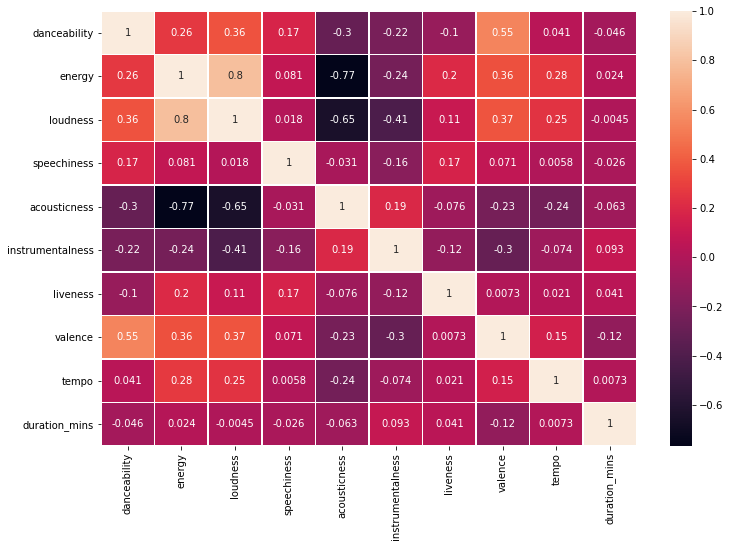

In [20]:
figsize=(12, 6)
corrMatrix = df_final.corr()
fig, ax = plt.subplots(figsize=(12,8))
sn.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)
plt.show()

In [21]:
df_inf = df_final.drop(columns='energy')
df_inf.head()

,danceability,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_mins
0,0.816,5,-10.357,0,0.2530,0.025900,0.000259,0.2050,0.753,86.154,4,1.329333
1,0.252,7,-4.297,0,0.0846,0.000008,0.820000,0.2630,0.458,144.043,4,8.414450
2,0.585,4,-10.970,0,0.0293,0.358000,0.717000,0.2950,0.331,110.899,4,9.028450
3,0.794,2,-10.838,1,0.0697,0.027000,0.904000,0.0716,0.171,126.019,4,6.507933
4,0.734,6,-7.855,0,0.0623,0.151000,0.725000,0.0857,0.541,125.062,4,5.421050


* We will fit a linear regression model to our data to dissecting Valence.
* Based on Spotify documentation, variables 'mode' & 'key' shoud be treated as categorical variables (so as they have been passed as str data types).
* For that reason, we created dummy variables for each one level of them.

In [22]:
dummy_vars = pd.get_dummies(df_inf[['mode','key','time_signature']])
dummy_vars

,mode_0,mode_1,key_0,key_1,key_10,key_11,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15906,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
15907,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
15908,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
15909,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


* Now that we have created our dummy variables, we will use N-1 levels of them.
* We concatenate the dummy variables with the rest variables to build our final set of predictors.

#### Model fitting - Linear regression

In [23]:
x = df_inf.drop(columns=['valence','mode','key','time_signature'])
x = pd.concat([x, dummy_vars.drop(columns=['mode_0','key_0','time_signature_0'])], axis=1)
x = sm.add_constant(x)
y = df_inf['valence']
model_inf = sm.OLS(y,x)
model_inf_res = model_inf.fit()
model_inf_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     397.9
Date:                Wed, 20 Apr 2022   Prob (F-statistic):               0.00
Time:                        01:08:46   Log-Likelihood:                 1846.0
No. Observations:               15899   AIC:                            -3642.
Df Residuals:                   15874   BIC:                            -3450.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1374      0.039      3.547      0.000       0.061       0.213
danceability         0.6947      0.010     66.949      0.000       0.674       0.715
loudness             0.0058      0.000     15.083      0.000       0.005       0.007
speechiness         -0.0758      0.015     -5.229      0.000      -0.104      -0.047
acousticness         0.0391      0.006      6.199      0.000       0.027       0.051
instrumentalness    -0.0958      0.005    -18.063      0.000      -0.106      -0.085
liveness             0.0509      0.009      5.683      0.000       0.033       0.068
tempo                0.0009   5.97e-05     14.275      0.000       0.001       0.001
duration_mins       -0.0078      0.001    -13.248      0.000      -0.009      -0.007
mode_1               0.0183      0.004      4.886      0.000       0.011       0.026
key_1               -0.0298      0.008     -3.914      0.000      -0.045      -0.015
key_10               0.0183      0.008      2.155      0.031       0.002       0.035
key_11               0.0039      0.008      0.487      0.626      -0.012       0.020
key_2                0.0202      0.007      2.859      0.004       0.006       0.034
key_3                0.0125      0.011      1.179      0.239      -0.008       0.033
key_4               -0.0012      0.008     -0.155      0.876      -0.017       0.014
key_5                0.0181      0.008      2.345      0.019       0.003       0.033
key_6                0.0010      0.009      0.122      0.903      -0.016       0.018
key_7                0.0132      0.007      1.910      0.056      -0.000       0.027
key_8                0.0082      0.009      0.918      0.358      -0.009       0.026
key_9                0.0176      0.007      2.403      0.016       0.003       0.032
time_signature_1    -0.0956      0.041     -2.318      0.020      -0.176      -0.015
time_signature_3    -0.0824      0.039     -2.114      0.035      -0.159      -0.006
time_signature_4    -0.0615      0.039     -1.585      0.113      -0.138       0.015
time_signature_5    -0.0996      0.040     -2.477      0.013      -0.178      -0.021
==============================================================================
Omnibus:                      186.178   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.239
Skew:                           0.079   Prob(JB):                     1.73e-27
Kurtosis:                       2.599   Cond. No.                     6.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.23e+03. This might indicate that there are
strong multicollinearity or other numerical probl

#### Model results
* The model that has been built can explain the 37.5% of the variance of valence.
* All variables are statistical significant at a 5% level of significance.
* For the dummy variables, even though some levels are not shown as statistical significant, we would keep the variables in the model.
---
#### Interpretation of coefficients
* A unit increase in danceability would increase valence by 0.69, with all the others variables stable.

## Q2: Predict Valence

### Prediction methods
* We will use 3 different methods for prediction:
    * Linear Regression
    * Decision Trees
    * LightGBM (boosted trees)
---
* Before the final evaluation of our model with the dataset that will be shared from the professor, we should conclude to the best model from our arsenal.
* The metric that will be used to compare models is Mean Absolute Error (MAE).
* We would use 10-fold cross validation to gain a solid picture of the MAE and avoid any erros durings train-test split.

In [24]:
# dataset for linear regression
df_lm = pd.concat([x, df1['energy']], axis=1)
x_lm = df_lm
y_lm = y
# dataset for Decision Trees & LightGBM
df_tr = pd.concat([x, df1['energy'], dummy_vars[['mode_0','key_0','time_signature_0']]], axis=1)
x_tr = df_tr.drop(columns='const')
y_tr = y

### Linear Regression

In [25]:
# define of cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [26]:
# building a multiple linear regression model
model_prd_lm = LinearRegression()
scores_lm = cross_val_score(model_prd_lm, x_lm, y_lm, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
mae_lm = mean(absolute(scores_lm))
print(round(mae_lm,3))

0.169


In [27]:
df_cv = pd.DataFrame(scores_lm, columns=['LM'])
df_cv

,LM
0,-0.175135
1,-0.165858
2,-0.168090
3,-0.167523
4,-0.170307
5,-0.162179
6,-0.169638
7,-0.173654
8,-0.168930
9,-0.171156


### Decision Trees

* Decision Trees performance varies based on parameters setted.
* Thus, it makes sesnse to find the best parameters' values to achieve our purpose (accurate prediction to unseen data), but this is a challenging process.
* Firstly, we fit a regression tree with default parameters.

In [28]:
dec_tree = DecisionTreeRegressor(criterion='mae')
scores_dec_tree = cross_val_score(dec_tree, x_tr, y_tr, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
mae_dec_tree = mean(absolute(scores_dec_tree))
print(round(mae_dec_tree,3))

0.214


* The default parameters, gave us a ~0.21 MAE. Can we achieve something better?

#### Decision Trees - Tuning hyperparameters
* The parameters that we will tune are:
    * depth of the trees
    * minimun number of samples to split an internal node
* The approach would be to fit for a range of values the model and then by obtaining the cross-validated MAE for each value, we would find the levels that we obtain the lower Mean Absolute Error.
* In the end, we would combine the parameters that we have found for the final model.

#### Max depth

In [29]:
depth_cv_scores = pd.DataFrame()
i = 1
while i <= 12:
    tree_tun = DecisionTreeRegressor(criterion='mae', max_depth=i)
    scores_tree_tun = cross_val_score(tree_tun, x_tr, y_tr, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    depth_cv_scores.loc[i,'MAE'] = mean(absolute(scores_tree_tun))
    print(i,end='\r')
    i=i+1

* From the plot below, we conclude that the lower MAE is by having a max depth at 8.

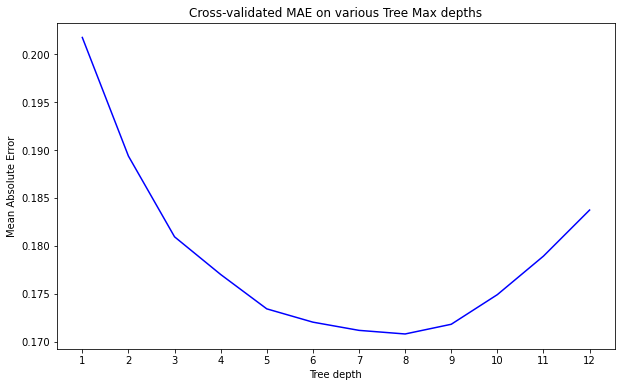

In [30]:
plt.figure(figsize=(10,6))
max_depths = np.linspace(1, i-1, i-1, endpoint=True)
line1, = plt.plot(max_depths, depth_cv_scores['MAE'], 'b')
plt.xticks(max_depths)
plt.title("Cross-validated MAE on various Tree Max depths")
plt.ylabel('Mean Absolute Error')
plt.xlabel('Tree depth')
plt.show()

#### Minimun number of samples to split an internal node

In [31]:
samples_cv_scores = pd.DataFrame()
a = 0.1
while a <= 1:
    tree_tun = DecisionTreeRegressor(criterion='mae',max_depth=8, min_samples_split=a)
    scores_tree_tun = cross_val_score(tree_tun, x_tr, y_tr, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    samples_cv_scores.loc[a,'MAE'] = mean(absolute(scores_tree_tun))
    print(round(a,1),end='\r')
    a = a + 0.1

* From the plot below, we conclude that the lower MAE is by having a minimum samples split of 10%.

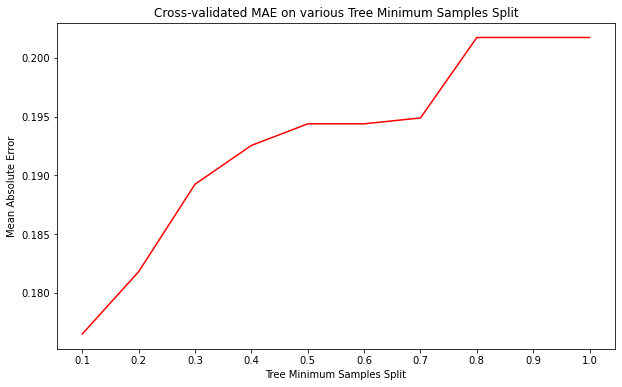

In [32]:
plt.figure(figsize=(10,6))
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
line, = plt.plot(min_samples_split, samples_cv_scores['MAE'], 'r')
plt.xticks(min_samples_split)
plt.title("Cross-validated MAE on various Tree Minimum Samples Split")
plt.ylabel('Mean Absolute Error')
plt.xlabel('Tree Minimum Samples Split')
plt.show()

In [33]:
final_tree = DecisionTreeRegressor(criterion='mae', max_depth=8, min_samples_split=0.1)
scores_final_tree = cross_val_score(final_tree, x_tr, y_tr, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
mae_final_tree = mean(absolute(scores_final_tree))
print(round(mae_final_tree,3))

0.176


* By tuning some important hyperparameters, we improved our models' performance from 0.214 to 0.176.

In [34]:
df_cv['Dec.Tree'] = pd.DataFrame(scores_final_tree)
df_cv

,LM,Dec.Tree
0,-0.175135,-0.180672
1,-0.165858,-0.171996
2,-0.168090,-0.175208
3,-0.167523,-0.180730
4,-0.170307,-0.175554
5,-0.162179,-0.171753
6,-0.169638,-0.173535
7,-0.173654,-0.182087
8,-0.168930,-0.173719
9,-0.171156,-0.179458


### LightGBM

In [35]:
lgb_reg = lgb.LGBMRegressor()
scores_lgb = cross_val_score(lgb_reg, x_tr, y_tr, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
mae_lgb = mean(absolute(scores_lgb))
print(round(mae_lgb,4))

0.1519


* However, we have to examine if we can get improved results by tuning the hyperparameters of LightGBM.
* The hyperparameters that we will tune are: 
    * number of leaves
    * max depth

In [57]:
lightgb_tun_cv_scores = pd.DataFrame()
z = 20
while z <= 120:
    l = 4
    while l <= 20:
        lgb_reg = lgb.LGBMRegressor(num_leaves=z, max_depth=l, metric='mae')
        scores_lgb_tun = cross_val_score(lgb_reg, x_tr, y_tr, scoring='neg_mean_absolute_error',cv=cv, n_jobs=-1)
        lightgb_tun_cv_scores.loc[z,l] = mean(absolute(scores_lgb_tun))
        l = l + 2
    print(z,end='\r')
    z=z+20

* As we can notice from the matrix below, the best combination of number of leaves and max depth are (60,10) respectively.
* With these parameters we will make our final LGBM model.

In [58]:
lightgb_tun_cv_scores.style.applymap(lambda x: 'background-color : yellow' if x==lightgb_tun_cv_scores.min().min() else '')

,4,6,8,10,12,14,16,18,20
20,0.154770,0.152627,0.152641,0.152507,0.152495,0.152578,0.152566,0.152566,0.152566
40,0.154770,0.152211,0.151679,0.151482,0.151635,0.151773,0.151651,0.151662,0.151603
60,0.154770,0.152195,0.151633,0.151307,0.151755,0.151365,0.151598,0.151503,0.151485
80,0.154770,0.152096,0.151784,0.151722,0.151694,0.151434,0.151673,0.151811,0.151828
100,0.154770,0.152096,0.152031,0.151965,0.151862,0.151826,0.151655,0.151912,0.152160
120,0.154770,0.152096,0.151896,0.152054,0.151900,0.152085,0.152166,0.152165,0.152097


In [93]:
lgbm_final = lgb.LGBMRegressor(num_leaves=60, max_depth=10, metric='mae')
scores_lgbm_final = cross_val_score(lgbm_final, x_tr, y_tr, scoring='neg_mean_absolute_error',cv=cv, n_jobs=-1)
df_cv['LGBM'] = pd.DataFrame(scores_lgbm_final)
print(round(mean(absolute(scores_lgbm_final)),4))

0.1513


In [94]:
df_cv

,LM,Dec.Tree,LGBM
0,-0.175135,-0.180672,-0.157308
1,-0.165858,-0.171996,-0.148284
2,-0.168090,-0.175208,-0.149732
3,-0.167523,-0.180730,-0.150120
4,-0.170307,-0.175554,-0.150048
5,-0.162179,-0.171753,-0.147664
6,-0.169638,-0.173535,-0.152787
7,-0.173654,-0.182087,-0.156962
8,-0.168930,-0.173719,-0.147146
9,-0.171156,-0.179458,-0.153022


### Overview of our models
* In the boxplot below are presented the 10-fold cross-validations mean absolute errors.
* It is obvisously shown that LGBM is by far the better model. LGBM will be used for the provided train dataset.

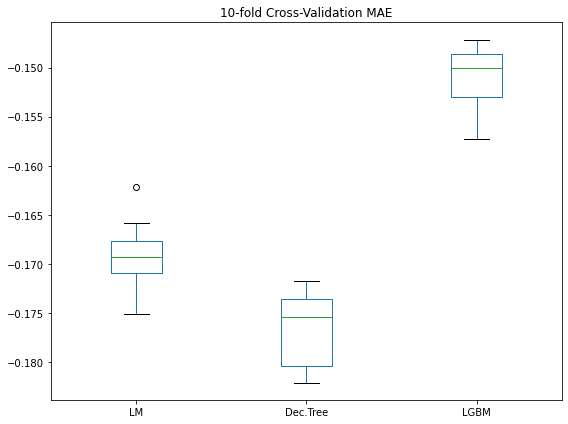

In [95]:
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.autolayout"] = True
ax = df_cv[['LM', 'Dec.Tree','LGBM']].plot(kind='box', title='10-fold Cross-Validation MAE')
plt.show()

### Final model evaluation

* Loading test dataset

In [77]:
test_ids = pd.read_csv('./spotify_ids.txt', sep=" ", names=['track_id'], header=None)
test_ids

,track_id
0,7lPN2DXiMsVn7XUKtOW1CS
1,5QO79kh1waicV47BqGRL3g
2,0VjIjW4GlUZAMYd2vXMi3b
3,4MzXwWMhyBbmu6hOcLVD49
4,5Kskr9LcNYa0tpt5f0ZEJx
...,...
1157,4lUmnwRybYH7mMzf16xB0y
1158,1fzf9Aad4y1RWrmwosAK5y
1159,3E3pb3qH11iny6TFDJvsg5
1160,3yTkoTuiKRGL2VAlQd7xsC


In [78]:
features_test = {}
start = 0
num_tracks = 100
while start < len(test_ids):
    print(f'getting from {start} to {start+num_tracks}',end='\r')
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features_test.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks

In [79]:
df_test = pd.DataFrame.from_dict(features_test)
df_test = df_test.T.drop(columns=['type','id','uri','track_href','analysis_url'])
df_test['duration_mins'] = (df_test['duration_ms']/1000)/60
df_test.drop(columns=['duration_ms'], inplace=True)
df_test

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_mins
1gtQd9BHwYh80MimqdVJSP,0.816,0.459,5,-10.357,0,0.253,0.0259,0.000259,0.205,0.753,86.154,4,1.329333
3MPW9khuVrceLkNbh09wv9,0.252,0.951,7,-4.297,0,0.0846,0.000008,0.82,0.263,0.458,144.043,4,8.41445
5TUS4o1SFKIEnZImVxXeJQ,0.585,0.838,4,-10.97,0,0.0293,0.358,0.717,0.295,0.331,110.899,4,9.02845
41DCKqkrN2SdxGS1KAl9UR,0.794,0.661,2,-10.838,1,0.0697,0.027,0.904,0.0716,0.171,126.019,4,6.507933
2JAfWUXVvhkKrJvcDFoQWP,0.734,0.955,6,-7.855,0,0.0623,0.151,0.725,0.0857,0.541,125.062,4,5.42105
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2KNbYStDtSSotL2v94EbpR,0.865,0.712,11,-4.637,0,0.205,0.0004,0.801,0.317,0.706,130.03,4,3.69615
4WtNHNmuLj5jet8gh8PZHN,0.398,0.462,11,-13.481,0,0.0316,0.636,0.613,0.303,0.382,120.019,4,6.84245
4oONPGlybgR0ip8hGKopcu,0.494,0.693,2,-11.509,1,0.0369,0.0364,0.000108,0.0814,0.454,128.556,4,3.553783
4S5MU2rrPqkGYWp98vFVvj,0.706,0.909,5,-5.157,1,0.0508,0.00358,0.000058,0.311,0.733,129.005,4,3.113117


In [80]:
test_cols_type = {'danceability': float,
            'key': str,
            'energy': float,
            'loudness': float,
            'mode': str,
            'speechiness': float,
            'acousticness': float,
            'instrumentalness': float,
            'liveness': float,
            'valence': float,
            'tempo': float,
            'duration_mins': float,
            'time_signature': str}
df_test = df_test.astype(test_cols_type)

In [81]:
df_test.dropna(inplace=True)
dummies_test = pd.get_dummies(df_test[['mode','key','time_signature']])
df_test1 = pd.concat([df_test,dummies_test], axis=1).drop(columns=['mode','key','time_signature'])
df_test1

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,...,key_5,key_6,key_7,key_8,key_9,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
1gtQd9BHwYh80MimqdVJSP,0.816,0.459,-10.357,0.2530,0.025900,0.000259,0.2050,0.753,86.154,1.329333,...,1,0,0,0,0,0,0,0,1,0
3MPW9khuVrceLkNbh09wv9,0.252,0.951,-4.297,0.0846,0.000008,0.820000,0.2630,0.458,144.043,8.414450,...,0,0,1,0,0,0,0,0,1,0
5TUS4o1SFKIEnZImVxXeJQ,0.585,0.838,-10.970,0.0293,0.358000,0.717000,0.2950,0.331,110.899,9.028450,...,0,0,0,0,0,0,0,0,1,0
41DCKqkrN2SdxGS1KAl9UR,0.794,0.661,-10.838,0.0697,0.027000,0.904000,0.0716,0.171,126.019,6.507933,...,0,0,0,0,0,0,0,0,1,0
2JAfWUXVvhkKrJvcDFoQWP,0.734,0.955,-7.855,0.0623,0.151000,0.725000,0.0857,0.541,125.062,5.421050,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2KNbYStDtSSotL2v94EbpR,0.865,0.712,-4.637,0.2050,0.000400,0.801000,0.3170,0.706,130.030,3.696150,...,0,0,0,0,0,0,0,0,1,0
4WtNHNmuLj5jet8gh8PZHN,0.398,0.462,-13.481,0.0316,0.636000,0.613000,0.3030,0.382,120.019,6.842450,...,0,0,0,0,0,0,0,0,1,0
4oONPGlybgR0ip8hGKopcu,0.494,0.693,-11.509,0.0369,0.036400,0.000108,0.0814,0.454,128.556,3.553783,...,0,0,0,0,0,0,0,0,1,0
4S5MU2rrPqkGYWp98vFVvj,0.706,0.909,-5.157,0.0508,0.003580,0.000058,0.3110,0.733,129.005,3.113117,...,1,0,0,0,0,0,0,0,1,0


#### Evaluating LGBM model with the provided test dataset.

In [96]:
# fitting with train
lgbm_final.fit(x_tr, y_tr)
# evaluating with test
predicted_y = lgbm_final.predict(df_test1.drop(columns='valence'))
expected_y = df_test1.valence

* The Mean Absolute Error of our final model in the test dataset.

In [97]:
print(round(mean_absolute_error(expected_y, predicted_y),4))

0.2165
